In [1]:
import numpy as np 
import pandas as pd 
import random
import io
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,cohen_kappa_score,matthews_corrcoef
from sklearn.model_selection import train_test_split
from IPython.display import Image,display,clear_output
import pywt

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras import Model, layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout,Dense,Input,Conv2D,MaxPooling2D,Flatten,Activation

In [2]:
import warnings
warnings.filterwarnings('ignore')

Number of images in training:  4000
Number of images in testing:  1200


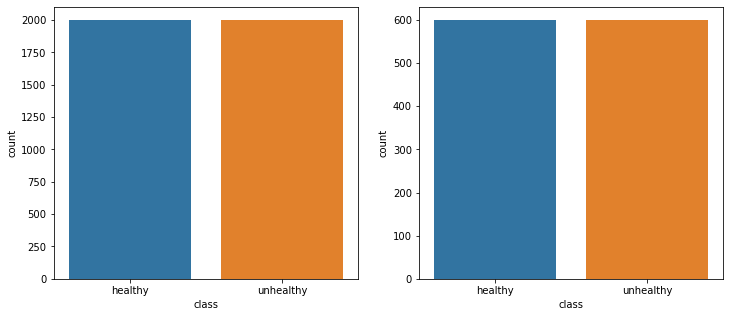

In [3]:
root_path = 'D:\\Prionto\\'
labels = []
trainFolder = root_path+'\\Train\\'
testFolder = root_path+'\\Test\\'

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(trainFolder):
    quantity_tr[folder] = len(os.listdir(trainFolder+folder))
    labels.append(folder)
    
for folder in os.listdir(testFolder):
    quantity_te[folder] = len(os.listdir(testFolder+folder))
    
    
quantity_train = pd.DataFrame(list(quantity_tr.items()),
                              index=range(0,len(quantity_tr)), columns=['class','count'])

quantity_test = pd.DataFrame(list(quantity_te.items()),
                              index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(12,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in training: ", sum(quantity_tr.values()))
print("Number of images in testing: ", sum(quantity_te.values()))

plt.show()

In [4]:
img_height = img_width = 128
batch_size = 32
labels

['healthy', 'unhealthy']

In [5]:
X_train = []
y_train = []

X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join(root_path,'Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(img_height, img_width))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(root_path,'Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j), 1)
        img = cv2.resize(img,(img_height, img_width))
        X_test.append(img)
        y_test.append(i)

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 504.46it/s]


In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [7]:
print(np.min(X_train), np.max(X_train))

0 255


In [8]:
X_train=X_train/255.0
X_test=X_test/255.0

In [9]:
print(np.min(X_train), np.max(X_train))

0.0 1.0


In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4000, 128, 128, 3) (4000,)
(1200, 128, 128, 3) (1200,)


In [11]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4000, 128, 128, 3) (4000, 2)
(1200, 128, 128, 3) (1200, 2)


In [14]:
train_datagen = ImageDataGenerator(        
        fill_mode="nearest",
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1
)
test_datagen = ImageDataGenerator()


train_ds = train_datagen.flow(
  X_train, y_train,
  subset="training",
  shuffle=True,
  batch_size=batch_size)

In [15]:
val_ds = train_datagen.flow(
  X_train, y_train,
  subset="validation",
  shuffle=True,
  batch_size=batch_size)

In [16]:
test_ds = test_datagen.flow(
  X_test, y_test,
  shuffle=False,
  batch_size=batch_size)

In [17]:
j = 0
class_mapping = {}
for i in labels:
    class_mapping[j] = i
    j+=1
    
class_mapping

{0: 'healthy', 1: 'unhealthy'}

In [18]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(testFolder)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(testFolder)):
        image_ids = os.listdir(os.path.join(testFolder,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = cv2.imread(os.path.join(testFolder,folder,image_ids[j]),1)
            display = cv2.resize(display, (img_height, img_width))/255.0
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True: '+folder
            if(predict_using_model):
                result = predict_using_model.predict(np.array([display]))
                #print(result)
                acc = str(round(np.max(result)*100, 3))
                predicted_classname = class_mapping[np.argmax(result)]
                title = title+'\nPrediction : '+predicted_classname+" - "+acc+"%"
            ax1[axs].set_title(title)
            axs=axs+1

In [19]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 128, 128, 3)
(32, 2)


In [25]:
tf.keras.backend.clear_session()
epoch = 35

In [26]:
def create_model(input_shape=(img_height, img_width, 3), n_classes = len(labels), optimizer='adam', fine_tune=0):
   

    conv_base = ResNet50(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)
   
    
    
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

   
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(n_classes, activation='sigmoid')(top_model)
    
   
    model = Model(inputs=conv_base.input, outputs=output_layer)


    
    return model
resnet50_final_model = create_model(fine_tune=0)
resnet50_final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [27]:
callbacks = [
tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                     patience=5,
                                     min_lr=0.000001,
                                     verbose=1)]

Metrics=['accuracy',
         [tf.keras.metrics.AUC(name='auc')],
         [tf.keras.metrics.Recall(name='recall')],
         [tf.keras.metrics.Precision(name='precision')]]

In [28]:
resnet50_final_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=Metrics)

In [29]:
resnet50_history = resnet50_final_model.fit(train_ds,
                                epochs = epoch,
                                validation_data = val_ds,
                                callbacks=callbacks,
                                verbose=1)

Epoch 1/35
113/113 [==============================] - 45s 374ms/step - loss: 0.7311 - accuracy: 0.5208 - auc: 0.5183 - recall: 0.5594 - precision: 0.5099 - val_loss: 0.6919 - val_accuracy: 0.5075 - val_auc: 0.5339 - val_recall: 0.9825 - val_precision: 0.5038 - lr: 0.0010
Epoch 2/35
113/113 [==============================] - 42s 375ms/step - loss: 0.6913 - accuracy: 0.5069 - auc: 0.5135 - recall: 0.5400 - precision: 0.5093 - val_loss: 0.6935 - val_accuracy: 0.4900 - val_auc: 0.4987 - val_recall: 0.4900 - val_precision: 0.4912 - lr: 0.0010
Epoch 3/35
113/113 [==============================] - 41s 363ms/step - loss: 0.6900 - accuracy: 0.5275 - auc: 0.5369 - recall: 0.5311 - precision: 0.5267 - val_loss: 0.6886 - val_accuracy: 0.5050 - val_auc: 0.5817 - val_recall: 0.5050 - val_precision: 0.5050 - lr: 0.0010
Epoch 4/35
113/113 [==============================] - 42s 368ms/step - loss: 0.6913 - accuracy: 0.5189 - auc: 0.5253 - recall: 0.5217 - precision: 0.5184 - val_loss: 0.6867 - val_accur

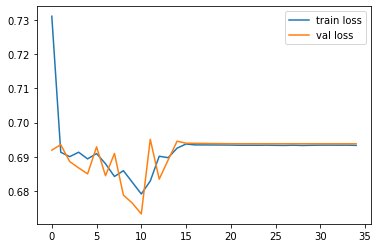

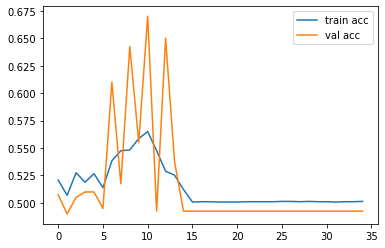

<Figure size 432x288 with 0 Axes>

In [30]:
# plot the loss
plt.plot(resnet50_history.history['loss'], label='train loss')
plt.plot(resnet50_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(resnet50_history.history['accuracy'], label='train acc')
plt.plot(resnet50_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [31]:
labels_pred= resnet50_final_model.predict(test_ds)

In [32]:
y_pred = tf.argmax(labels_pred, axis=1)
# y_pred

In [33]:
y_true = tf.argmax(y_test, axis = 1)
# y_true

              precision    recall  f1-score   support

     healthy       0.00      0.00      0.00       600
   unhealthy       0.50      1.00      0.67       600

    accuracy                           0.50      1200
   macro avg       0.25      0.50      0.33      1200
weighted avg       0.25      0.50      0.33      1200



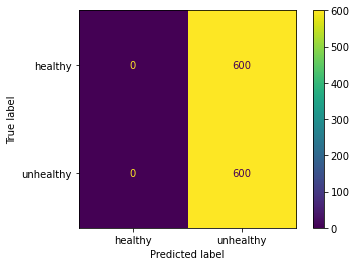

In [34]:
print(classification_report(y_true, y_pred, target_names=labels))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)
plt.show()